In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import pylab
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score

In [2]:
from sklearn import datasets as ds

df = ds.fetch_openml(data_id=151,as_frame=True, return_X_y=True)

# State the question and determine required data

In [3]:
df = (

    pd.concat(df, axis=1)

    .assign(target=lambda x: (x['class']=='UP')*1)

)

In [4]:
df.head()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class,target
0,0.0,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,UP,1
1,0.0,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,UP,1
2,0.0,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,UP,1
3,0.0,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,UP,1
4,0.0,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,DOWN,0


In [5]:
nswprice = df.nswprice
nswdemand = df.nswdemand
vicprice = df.vicprice
vicdemand = df.vicdemand

print('The shape of our features is:', df.shape)

The shape of our features is: (45312, 10)


In [6]:
# Descriptive statistics for each column
df.describe()

,date,period,nswprice,nswdemand,vicprice,vicdemand,transfer,target
count,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000
mean,0.499080,0.500000,0.057868,0.425418,0.003467,0.422915,0.500526,0.424545
std,0.340308,0.294756,0.039991,0.163323,0.010213,0.120965,0.153373,0.494279
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.031934,0.250000,0.035127,0.309134,0.002277,0.372346,0.414912,0.000000
50%,0.456329,0.500000,0.048652,0.443693,0.003467,0.422915,0.414912,0.000000
75%,0.880547,0.750000,0.074336,0.536001,0.003467,0.469252,0.605702,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


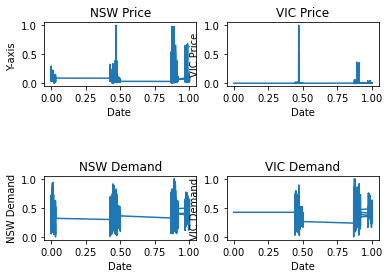

In [7]:
plt.subplot(3, 2, 1)
plt.plot(df.date, nswprice)
plt.title("NSW Price")
plt.xlabel('Date ')
plt.ylabel('Y-axis ')


plt.subplot(3, 2, 2)
plt.plot(df.date, vicprice)
plt.title("VIC Price")
plt.xlabel('Date')
plt.ylabel('VIC Price')

plt.subplot(3, 2, 5)
plt.plot(df.date, nswdemand)
plt.title("NSW Demand")
plt.xlabel('Date')
plt.ylabel('NSW Demand')

plt.subplot(3, 2, 6)
plt.plot(df.date, vicdemand)
plt.title("VIC Demand")
plt.xlabel('Date')
plt.ylabel('VIC Demand')

plt.show()

In [8]:
group_by_date = df.loc[:, ['date', 'nswprice', 'nswdemand']].groupby('date')
avgs = group_by_date.mean()
x = avgs.index
y1 = avgs.nswdemand
def plot(x, y, ax, title, y_label):
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.plot(x, y)
    ax.margins(x=0, y=0)

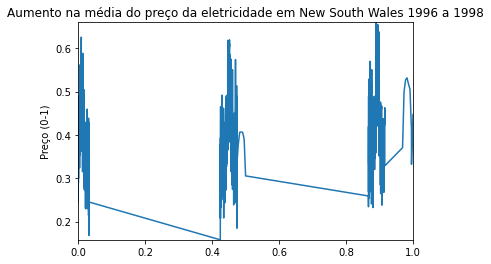

In [9]:
fig, ax = plt.subplots()
plot(x, y1, ax, 'Aumento na média do preço da eletricidade em New South Wales 1996 a 1998', 'Preço (0-1)')

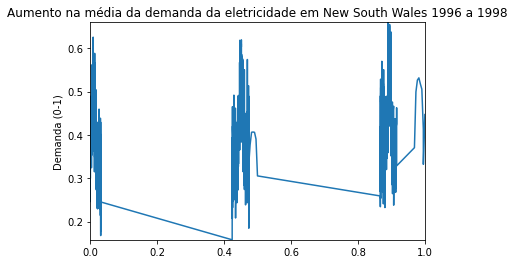

In [10]:
y2 = avgs.nswdemand
fig, ax = plt.subplots()
plot(x, y2, ax, 'Aumento na média da demanda da eletricidade em New South Wales 1996 a 1998', 'Demanda (0-1)')

In [11]:
## Testando Normalidade nas variáveis

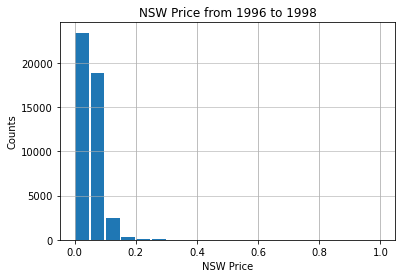

In [12]:
df.nswprice.plot.hist(grid=True,bins=20,rwidth=0.9)
plt.title('NSW Price from 1996 to 1998')
plt.ylabel('Counts')
plt.xlabel('NSW Price')
plt.grid(axis='y', alpha=0.75)

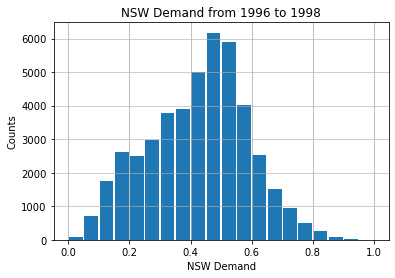

In [13]:
df.nswdemand.plot.hist(grid=True,bins=20,rwidth=0.9)
plt.title('NSW Demand from 1996 to 1998')
plt.ylabel('Counts')
plt.xlabel('NSW Demand')
plt.grid(axis='y', alpha=0.75)

Text(0.5, 0, 'NSW Demand')

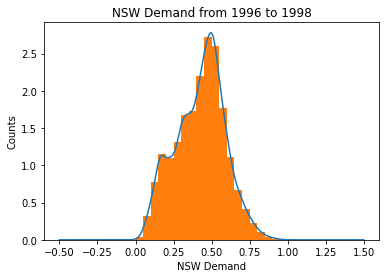

In [14]:
fig, ax = plt.subplots()
df.nswdemand.plot.kde(ax=ax, legend=False, title='NSW Demand from 1996 to 1998')
df.nswdemand.plot.hist(density=True, ax=ax,bins=20)
plt.ylabel('Counts')
plt.xlabel('NSW Demand')

<AxesSubplot:xlabel='nswprice', ylabel='Count'>

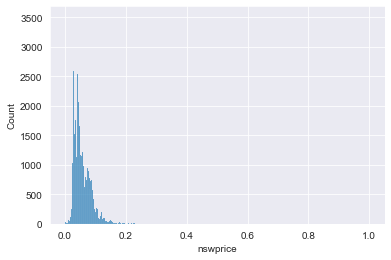

In [15]:
sns.set_style('darkgrid')
sns.histplot(df.nswprice)

<AxesSubplot:xlabel='vicprice', ylabel='Count'>

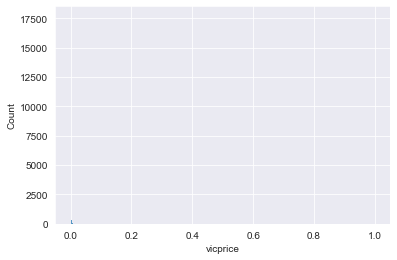

In [16]:
sns.set_style('darkgrid')
sns.histplot(df.vicprice)

<AxesSubplot:xlabel='nswdemand', ylabel='Count'>

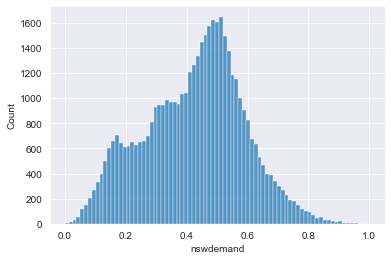

In [17]:
sns.histplot(df.nswdemand)

<AxesSubplot:xlabel='vicdemand', ylabel='Count'>

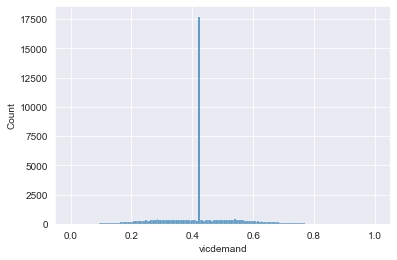

In [18]:
sns.histplot(df.vicdemand)

((array([-4.16899786, -3.9622    , -3.84941481, ...,  3.84941481,
          3.9622    ,  4.16899786]),
  array([0.      , 0.      , 0.      , ..., 0.981806, 0.981806, 1.      ])),
 (0.030221145123102266, 0.05786831013859463, 0.7556428703662484))

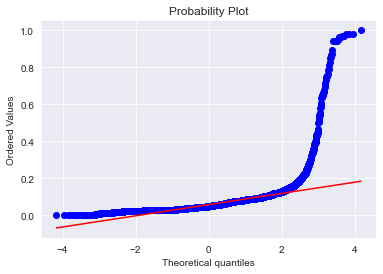

In [19]:
stats.probplot(df.nswprice, dist="norm", plot=pylab)

((array([-4.16899786, -3.9622    , -3.84941481, ...,  3.84941481,
          3.9622    ,  4.16899786]),
  array([0.      , 0.00119 , 0.001488, ..., 0.962511, 0.980809, 1.      ])),
 (0.16255185534600416, 0.4254178952595338, 0.9952009223530537))

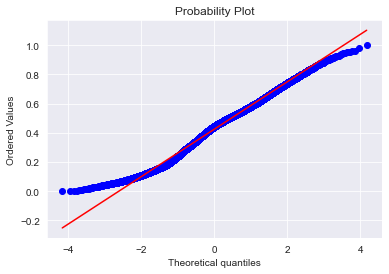

In [20]:
stats.probplot(df.nswdemand, dist="norm", plot=pylab)

((array([-4.16899786, -3.9622    , -3.84941481, ...,  3.84941481,
          3.9622    ,  4.16899786]),
  array([0.      , 0.      , 0.      , ..., 0.980682, 0.996228, 1.      ])),
 (0.002040413599105342, 0.0034670338983050835, 0.1997692688809712))

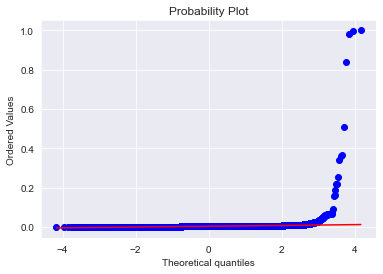

In [21]:
stats.probplot(df.vicprice, dist="norm", plot=pylab)

((array([-4.16899786, -3.9622    , -3.84941481, ...,  3.84941481,
          3.9622    ,  4.16899786]),
  array([0.      , 0.024081, 0.025634, ..., 0.991196, 0.996893, 1.      ])),
 (0.1174331447804295, 0.42291507571945613, 0.9707226174261446))

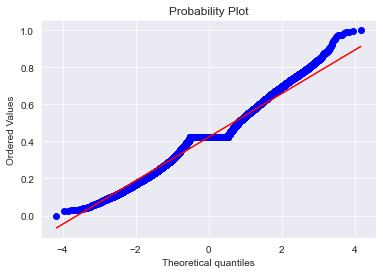

In [22]:
stats.probplot(df.vicdemand, dist="norm", plot=pylab)

In [39]:
x = df[['nswdemand','vicprice','vicdemand']]
y = df[['target']]

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=0)

In [40]:
log_regression = LogisticRegression()
log_regression.fit(x_train,y_train.values.ravel())

LogisticRegression()

In [41]:
y_pred = log_regression.predict(x_test)
# F1_score
results1 =[]
results1.append(f1_score(y_test,y_pred))
# Accuracy
print('Accuracy:', np.mean(results1))

Accuracy: 0.5358130662851692


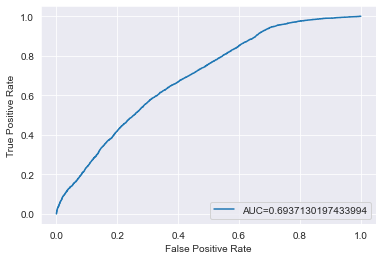

In [43]:
y_pred_proba = log_regression.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

AUC = 0.5 >> modelo não é melhor do que chutar ... AUC = 1 modelo acerta tudo ... O modelo acima não foi muito bom. 

In [44]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

#KFold para validar o modelo
#from sklearn.model_selection import KFold
#kf = KFold(n_splits=2, random_state = 42)
results = [] #para colocar os F1 scores

# Instantiate model with 100 decision trees
rf = RandomForestClassifier(n_estimators = 100, random_state = 0)
# Train the model on training data
rf.fit(x_train, y_train.values.ravel())

RandomForestClassifier(random_state=0)

In [45]:
# Use the forest's predict method on the test data
y_pred = rf.predict(x_test)
# F1_score
results.append(f1_score(y_test,y_pred))
# Accuracy
print('Accuracy:', np.mean(results))

Accuracy: 0.6036551596824811


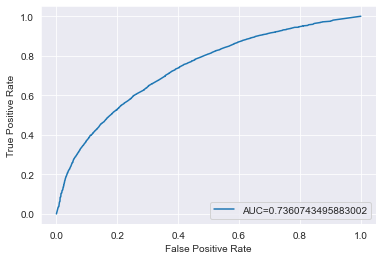

In [48]:
y_pred_proba = rf.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [67]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, random_state = 42, shuffle=True)
results = []

In [70]:
for train_index, test_index in kf.split(x):
    x_train, x_test = x.values[train_index], x.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    model = RandomForestClassifier(n_estimators = 1000, random_state = 24)
    model.fit(x_train, y_train.ravel())
    y_pred = model.predict(x_test)
    results.append(f1_score(y_test, y_pred))

In [71]:
print("Accuracy: ", np.mean(results))

Accuracy:  0.6026004798624792
